# Setup

## Imports

In [1]:
import os.path

from tqdm import tqdm_notebook
from time import time

OpenAI Gym Modules

In [2]:
import gym

PyTorch Modules

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable

vai Modules

In [4]:
from vai.vaidata import pickle_load, pickle_dump
from vai.utils.utils import path_consts

## Define Userful Features

In [5]:
for k, v in path_consts():
    exec(k + ' = v')

In [6]:
use_gpu = False

In [7]:
probabilistic = False

In [8]:
cuda = lambda x: x.cuda() if use_gpu and torch.cuda.is_available() else x

In [9]:
def get_parameters():
    weights = list(model.parameters())
    params = []
    for w in weights:
        params.append(w.data.cpu().numpy().reshape(-1))
    return np.hstack(params)

In [10]:
def set_parameters(parameters=None):
    if parameters is None: return
    global model
    param_idx = 0
    for s, param in zip(model.parameter_shapes, model.parameters()):
        num_params = np.prod(s)
        param.data = cuda(torch.from_numpy(parameters[param_idx:param_idx + num_params].reshape(s)))
        param_idx += num_params

In [11]:
def get_action(obs):
    action = model(Variable(cuda(torch.from_numpy(np.expand_dims(obs.astype(np.float32), 0))), volatile=True)).cpu().data.numpy()[0]
    if env.a == 1:
        return action
    elif env.a == 2:
        if probabilistic:
            return np.random.choice(2, p=[action[0], 1-action[0]])
        
        return (action > 0.5).astype(int)[0]
    elif probabilistic:
        return np.random.choice(env.a, p=action)
    
    return action.argmax()

In [12]:
def sample(episodes=1, observe=False):
    epoch_reward = 0
    for episode in range(episodes):
        env.reset()
        done = False
        obs = env.observation_space.sample()
        episode_reward = 0
        while not done:
            if observe:  env.render()
            obs, r, done, _ = env.step(get_action(obs))
            episode_reward += r
                
        epoch_reward += episode_reward
    if observe: env.render(close=True)
    return epoch_reward

In [13]:
def get_environment(environment='CartPole-v1'):
    env = gym.make(environment)

    env.n = env.observation_space.shape[0]
    env.a = env.action_space.shape
    env.a = env.action_space.n if len(env.a) == 0 else env.a[0]
    return env

In [14]:
env = get_environment()

In [15]:
num_episodes = 10
max_episode_reward = 500

# Create Model

In [16]:
def get_activation(activation):
    if activation == 'relu':
        return nn.ReLU(inplace=True)
    elif activation == 'sigmoid':
        return nn.Sigmoid()
    elif activation == 'tanh':
        return nn.Tanh()
    elif activation == 'softmax':
        return nn.Softmax()

In [17]:
def get_model(hidden_features=[], activation='tanh', use_gpu=False):
    Activation = get_activation(activation)
    
    if len(hidden_features) == 0:
        if env.a == 2:
            layers = [nn.Linear(env.n, 1), get_activation('sigmoid')]
        else:
            layers = [nn.Linear(env.n, env.a)]
    else:
        layers = [nn.Linear(env.n, hidden_features[0]), Activation]
        for i, h in enumerate(hidden_features[1:]):
            layers += [nn.Linear(hidden_features[i-1], h), Activation]
        if env.a == 2:
            layers.append(nn.Linear(hidden_features[-1], 1), get_activation('sigmoid'))
        else:
            layers.append(nn.Linear(hidden_features[-1], env.a))
        
    if env.a > 2:
        layers.append(get_activation('softmax'))
        
    model = cuda(nn.Sequential(*layers))
    model.parameter_shapes = [np.array(p.size()) for p in list(model.parameters())]
    model.num_parameters = sum([np.prod(s) for s in model.parameter_shapes])
    return model

In [18]:
model = get_model()
model

Sequential (
  (0): Linear (4 -> 1)
  (1): Sigmoid ()
)

# Evolutionary Algorithms

## Define Base Features

In [19]:
def evaluate(parameters=None):
    set_parameters(parameters)
    return sample(num_episodes)

In [20]:
class EvolutionSearch():
    def __init__(self, show_progress=False):
        self.best_parameters = None
        self.best_reward = -np.inf
        self.epochs_run = 0
        self.show_progress = show_progress
        self.progress = []
        
    def search(self, num_epochs=-1, max_episode_reward=None, verbose=True, timeout=100):
        if self.epochs_run == 0:
            self.best_parameters = get_parameters()
            self.best_reward = evaluate()
            self.progress.append((0, self.best_reward))
            
        start_time = time()
        if num_epochs == -1:
            while self.best_reward / num_episodes < max_episode_reward:
                self._search(verbose)
                if time() - start_time > timeout: break
        else:
            epoch_iterator = range(num_epochs)
            if verbose: epoch_iterator = tqdm_notebook(epoch_iterator)
            for epoch in epoch_iterator:
                self._search(verbose)
                if time() - start_time > timeout: break
            print(time() - start_time)
        set_parameters(self.best_parameters)
        print(time() - start_time)
                
    def _search(self, verbose=True):
        pass

In [21]:
def plot_progress(optimizer):
    progress = np.array(optimizer.progress).T
    plot(progress[0], progress[1] / num_episodes)

## Random Search

Searches randomly and selects the best performing model

In [22]:
class RandomSearch(EvolutionSearch):
    def __init__(self, param_generator=lambda: np.random.randn(model.num_parameters).astype(np.float32),
                 show_progress=False):
        super().__init__(show_progress)
        self.param_generator = param_generator
        
    def _search(self, verbose=True):
        parameters = self.param_generator()
        reward = evaluate(parameters)
        self.epochs_run += 1
        
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_parameters = parameters
            
            if verbose: print('Average reward:', int(reward / num_episodes), end='\r')
            self.progress.append((self.epochs_run, reward))
            if self.show_progress: sample(observe=True)

In [23]:
#optimizer = RandomSearch(show_progress=True)
#optimizer.search(max_episode_reward=max_episode_reward)

#plot_progress(optimizer)

## Spiral Search

Starts the search at a random point close to the best point and subsequently scans outwards. Although random, the pattern of searched points reminds one of a spiral.

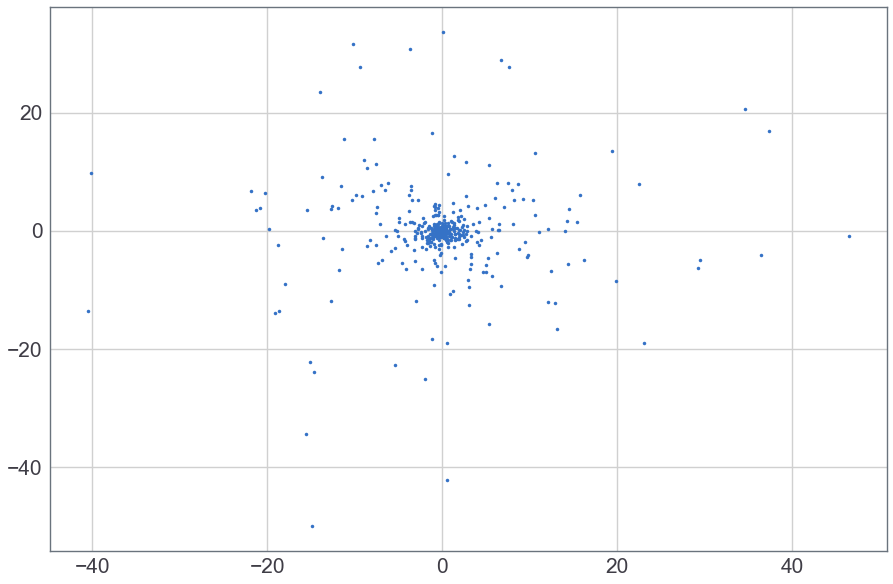

In [24]:
x = np.stack([np.random.randn(2) * 1e-3 * (1 + 1e-2) ** i for i in range(1000)]).T; plot(x[0], x[1], '.'); del x

In [25]:
class SpiralSearch(EvolutionSearch):
    def __init__(self, learning_rate=1e-3, spiral_rate=1e-2, show_progress=False):
        super().__init__(show_progress)
        self.initial_learning_rate = self.learning_rate = learning_rate
        self.spiral_rate = spiral_rate
        
    def _search(self, verbose=True):
        noise = np.random.randn(model.num_parameters).astype(np.float32) * self.learning_rate
        parameters = self.best_parameters + noise
        reward = evaluate(parameters)
        self.epochs_run += 1
        self.learning_rate *= (1 + self.spiral_rate)
        
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_parameters = parameters
            
            self.learning_rate = self.initial_learning_rate
            
            if verbose: print('Average reward:', int(reward / num_episodes), end='\r')
            self.progress.append((self.epochs_run, reward))
            if self.show_progress: sample(observe=True)

In [26]:
#model = get_model()

#optimizer = SpiralSearch(show_progress=True)
#optimizer.search(max_episode_reward=max_episode_reward)

#plot_progress(optimizer)

# Test Model

In [27]:
def optimize(environment='CartPole-v1', max_episode_reward=500, hidden_features=[],
             activation='relu', GPU=False, deterministic=True, optimizer=None, num_epochs=-1,
             verbose=True, timeout=100, episodes_per_epoch=10):
    global model, num_episodes, probabilistic, env, use_gpu
    use_gpu = GPU
    env = get_environment(environment)
    model = get_model(hidden_features, activation, use_gpu)
    num_episodes = episodes_per_epoch
    probabilistic = not deterministic
    
    if optimizer is None: optimizer = RandomSearch()
    if type(optimizer) is str:
        optimizer = pickle_load(os.path.join(DIR_CHECKPOINTS, environment + '-' + optimizer + '.p'), has_lambda=True)

    optimizer.search(num_epochs, max_episode_reward, verbose, timeout)
    
    plot_progress(optimizer)
    
    pickle_dump(os.path.join(DIR_CHECKPOINTS, environment + '-optimizer.p'), optimizer, has_lambda=True)

HBox(children=(IntProgress(value=0), HTML(value='')))

Average reward: -1137
17.500171422958374
17.500269412994385


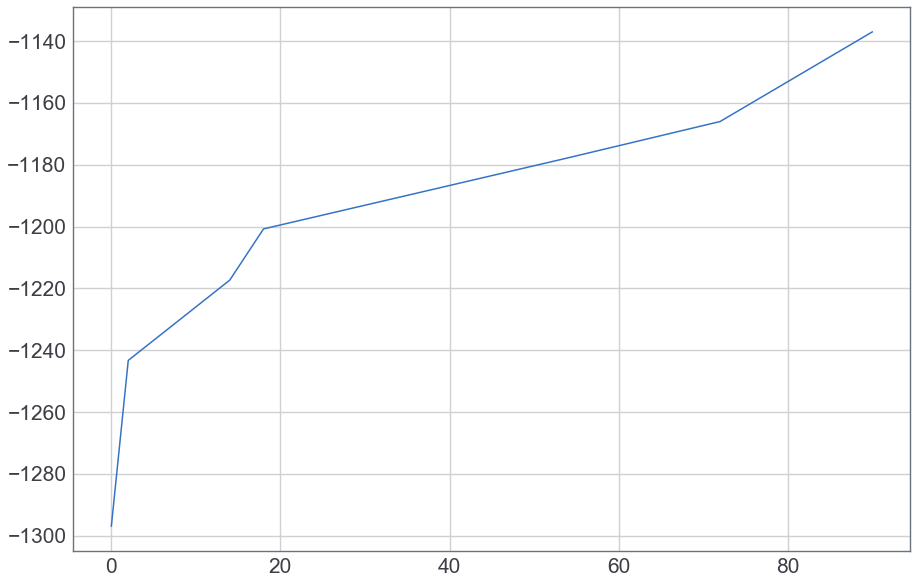

In [28]:
optimize('Pendulum-v0', num_epochs=100, optimizer=SpiralSearch(), hidden_features=[10])

In [29]:
#sample(5, observe=True)